# Hybrid System Example:

This is Example 2.1 from the book "Impulsive and Hybrid Dynamical Systems: Stability, Dissipativity, and Control, Haddad, Chellaboina, Nersesov".

---
Consider the scalar impulsive dynamical system originally studies in [12] given by

###  $$ \dot{x}(t) = 0$, $x(0) = x_0$, $(t, x(t)) \notin S$$
###  $$\Delta x(t) = x^2(t)\textrm{sgn}x(t) - x(t)$, $(t,x(t))\in S$$

Where, $\textrm{sgn} \stackrel{\Delta}{=} x/\lvert x\rvert$, $x \neq 0$, $\textrm{sgn(0)} \stackrel{\Delta}{=} 0$, and 

### $S = (t,x) \in \bar{\mathbb{R}}_{+} \times \mathbb{R}: \lvert x \rvert < 3$, and $t = x + 6*k$, $k \in \bar{\mathbb{Z}}_{+}$

---
[12]: D. D. Bainov and P.S. Simeonov, Systems with Impulse Effect: Stability, Theory and Applications. Chichester, U.K.: Ellis Horwood, 1989

In [1]:
import numpy as np
from pydrake.common.containers import namedview
from pydrake.common.value import Value
from pydrake.math import RigidTransform, RotationMatrix
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import BasicVector, LeafSystem
from pydrake.trajectories import PiecewisePolynomial
from pydrake.all import LogVectorOutput
from pydrake.all import DiagramBuilder

from pydrake.systems.framework import WitnessFunctionDirection
from pydrake.systems.framework import UnrestrictedUpdateEvent
from pydrake.systems.framework import EventStatus

from pydrake.systems.analysis import SimulatorConfig, ApplySimulatorConfig

import matplotlib.pyplot as plt

class HybridSystem(LeafSystem):
    def __init__(self):
        super().__init__()  # Don't forget to initialize the base class.

        self.name = "Example 2.1 from Impulsive and Hybrid Dynamical Systems"
        
        self.k = 0
        
        # Continuous State
        state_index = self.DeclareContinuousState(2)  
        self.DeclareStateOutputPort("y", state_index) 
    
        # https://drake.mit.edu/pydrake/pydrake.systems.framework.html?highlight=witnessfunction#pydrake.systems.framework.WitnessFunctio
        self.witness = self.MakeWitnessFunction(
            "witness", 
            WitnessFunctionDirection.kCrossesZero,
            self._guard,
            UnrestrictedUpdateEvent(self._reset)
        )
        
    def _guard(self, context):
        self.called_witness = True
        t = context.get_time()
        x = context.get_continuous_state_vector().GetAtIndex(0)
        k = self.k
        
        if (np.abs(x) < 3):
            for k in range(0, 10):
                if np.isclose(t - (x + 6*k), 0, atol=1e-1):
                    return t - (x + 6*k)
        else:
            return 1.0
        
        # Though shalt return in the main scope of the witness function.
        return 666.666

    
    def _reset(self, context, event, state):
        x = context.get_mutable_continuous_state_vector().GetAtIndex(0)
        xd = context.get_mutable_continuous_state_vector().GetAtIndex(1)
        del_x = x**2 * np.sign(x) - x
    
        t = context.get_time()
        if (x + del_x < (t - (x + 6*self.k))):
            self.k += 1
    
        state.get_mutable_continuous_state().get_mutable_vector().SetFromVector(
            [x+del_x, xd]
        )
    
    def DoCalcTimeDerivatives(self, context, derivatives):
        x = context.get_continuous_state_vector().GetAtIndex(0)
        xd = context.get_continuous_state_vector().GetAtIndex(1)
        derivatives.get_mutable_vector().SetAtIndex(0, xd)
        derivatives.get_mutable_vector().SetAtIndex(1, 0)

    def DoGetWitnessFunctions(self, context):
        #print("bloop")
        self.called_getwitness = True
        return [self.witness]
             

Simulating with ics:  [-3, 0]
Simulating with ics:  [-1, 0]
Simulating with ics:  [-0.5, 0]
Simulating with ics:  [0.5, 0]
Simulating with ics:  [1, 0]
Simulating with ics:  [4.2, 0]
Simulating with ics:  [1.189207115002721, 0]


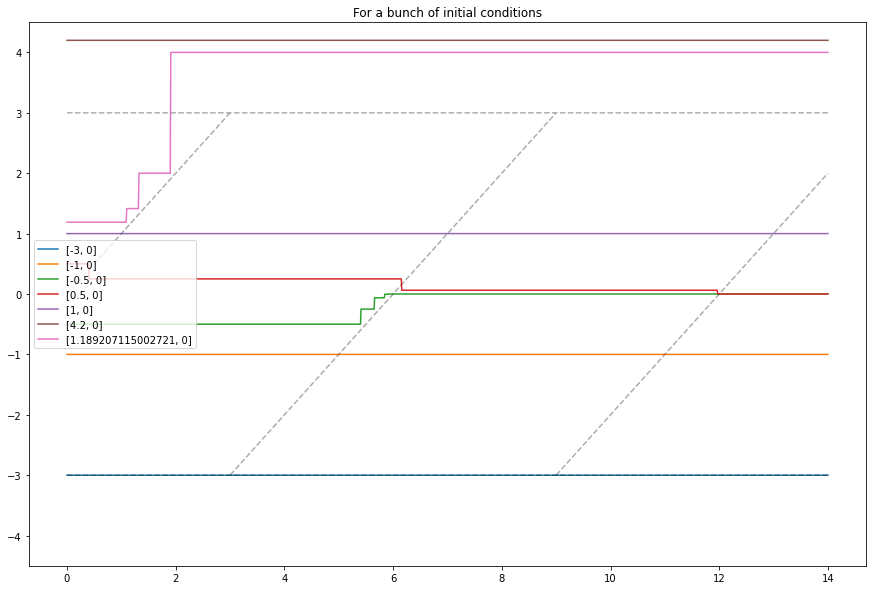

In [2]:
# Construct an instance of this system and a context.
system = HybridSystem()
context = system.CreateDefaultContext()

builder = DiagramBuilder()
builder.AddSystem(system)
logger = LogVectorOutput(system.GetOutputPort('y'), builder)

builder.ExportOutput(system.GetOutputPort('y'))
diagram = builder.Build()

def RunHybrid(ics, showSimStatus=True):
    simulator = Simulator(diagram)

    # We apply some sim_configs because this hybrid
    # system is a little fussy...
    simconf = SimulatorConfig(accuracy=1e-10, max_step_size=0.01)
    ApplySimulatorConfig(simconf, simulator)

    sim_context = simulator.get_mutable_context()

    # Set the initial conditions:
    sim_context.SetTime(0)
    sim_context.SetContinuousState(ics)
    
    # We use this to keep track of the "contact" surface.
    system.k = 0

    # If the "accuracy" is not set (tightened)
    # Throws: RuntimeError: Integrator is not operating 
    # in fixed step mode and accuracy is not set in the context.
    sim_context.SetAccuracy(1e-10)

    if (showSimStatus):
        print("Simulating with ics: ", ics)

    # Run the simulation forward.
    simulator.AdvanceTo(14)

    log = logger.FindLog(sim_context)

    plt.plot(log.sample_times(), log.data()[0], label=str(ics))

    t_cut = []
    for k in range(0, 5):
        t_cutoff_max = log.sample_times()[(log.sample_times() - 6*k) <= 3]   
        t_cut.append(t_cutoff_max[(t_cutoff_max - 6*k) >= -3])
        plt.plot(t_cut[-1], t_cut[-1] - 6*k, "--", color="black", alpha=0.05)

    plt.plot(log.sample_times(), 3*np.ones(len(log.sample_times())), "--", color="black", alpha=0.05)
    plt.plot(log.sample_times(), -3*np.ones(len(log.sample_times())), "--", color="black", alpha=0.05)

    plt.ylim(-4.5, 4.5)
    plt.title("For a bunch of initial conditions")

plt.figure(figsize=(15, 10))
RunHybrid([-3, 0])
RunHybrid([-1, 0])
RunHybrid([-0.5, 0])
RunHybrid([0.5, 0])
RunHybrid([1, 0])
RunHybrid([4.2, 0])
RunHybrid([np.float_power(2, 1/4), 0])
plt.legend()
plt.show()

# If you have a lot of time on your hands to wait for the simulation, bump 'num_to_viz up to 100

Simulating, be patient (100 sims at this timestep will take a long time)...


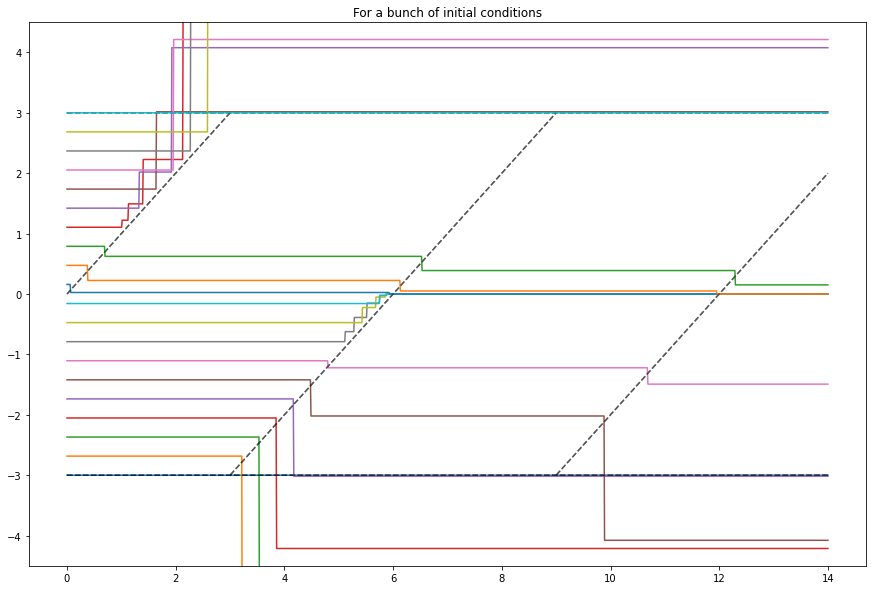

In [3]:
plt.figure(figsize=(15, 10))

print("Simulating, be patient (100 sims at this timestep will take a long time)...")
num_to_viz = 20
for x0 in np.linspace(-3, 3, num_to_viz, endpoint=True):
    RunHybrid([x0, 0], showSimStatus=False)

plt.show()